# Classification-GoogleNet

# 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.
* `['figure.figsize'] = (10, 10)`: figure size (10\*80,10\*80) pixels
> [rcParams](http://old.sebug.net/paper/books/scipydoc/matplotlib_intro.html)
* 使用%matplotlib命令可以将matplotlib的图表直接嵌入到Notebook之中，或者使用指定的界面库显示图表

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load `caffe`.
* should be run from `{caffe_root}/examples`

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python') # caffe/python

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

* If needed, download the reference model (["GoogleNet"](http://dl.caffe.berkeleyvision.org/bvlc_googlenet.caffemodel)).

In [3]:
import os
if os.path.isfile(caffe_root + 'models/bvlc_googlenet/bvlc_googlenet.caffemodel'):
    print 'Google-Net found.'
else:
    print 'You must download pre-trained GoogleNet model...'

Google-Net found.


### 2. Load net and set up input preprocessing

* Set Caffe to CPU mode and load the net from disk.
* ## make net!

In [4]:
caffe.set_mode_cpu()

#model_def = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
#model_weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

model_def = caffe_root + 'models/bvlc_googlenet/deploy.prototxt'
model_weights = caffe_root + 'models/bvlc_googlenet/bvlc_googlenet.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

* Set up input preprocessing. (We'll use Caffe's `caffe.io.Transformer` to do this, but this step is independent of other parts of Caffe, so any custom preprocessing code may be used).

    ** Our default CaffeNet is configured to take images in `BGR` format. Values are expected to start in the range `[0, 255]` and then have the mean ImageNet pixel value subtracted from them. In addition, the channel dimension is expected as the first (_outermost_) dimension.**
    
    ** As `matplotlib` will load images with values in the range [0, 1] in `RGB` format with the channel as the _innermost_ dimension, we are arranging for the needed transformations here.**

In [5]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

* [Python zip()](http://www.runoob.com/python/python-func-zip.html)

In [6]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


### 3. CPU classification

* Now we're ready to perform classification. Even though we'll only classify one image, we'll set a batch size of 50 to demonstrate batching.

* Load an image (that comes with Caffe) and perform the preprocessing we've set up.

In [7]:
image = caffe.io.load_image(caffe_root + 'examples/images/cat.jpg')
print "raw image.shape: ", image.shape
transformed_image = transformer.preprocess('data', image)
print "transformed_image.shape: ", transformed_image.shape

raw image.shape:  (360, 480, 3)
transformed_image.shape:  (3, 227, 227)


* Adorable! Let's classify it!

In [8]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[0,:,:,:] = transformed_image # [0,:,:,:] means 0th image in batch_size

### perform classification
output = net.forward()

output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

print 'predicted class is:', output_prob.argmax()

predicted class is: 282


* The net gives us a vector of probabilities; the most probable class was the 281st one. But is that correct? Let's check the ImageNet labels...
* [np.loadtxt](https://docs.scipy.org/doc/numpy/reference/generated/numpy.loadtxt.html#numpy.loadtxt)

In [9]:
# load ImageNet labels
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt' # ImageNet labels
# Not exist, just download it.
if not os.path.exists(labels_file):
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

print 'output label:', labels[output_prob.argmax()]

output label: n02123159 tiger cat


* "Tabby cat" is correct! But let's also look at other top (but less confident predictions).

* [Python zip()](http://www.runoob.com/python/python-func-zip.html)

In [10]:
# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items
print 'top_inds: '+ str(top_inds)
# or
# print 'top_inds: ', top_inds
print '\nprobabilities and labels:'
zip(output_prob[top_inds], labels[top_inds]) # * [Python zip()](http://www.runoob.com/python/python-func-zip.html)

top_inds: [282 281 285 283 287]

probabilities and labels:


[(0.49444053, 'n02123159 tiger cat'),
 (0.25947443, 'n02123045 tabby, tabby cat'),
 (0.10331757, 'n02124075 Egyptian cat'),
 (0.047910824, 'n02123394 Persian cat'),
 (0.04205771, 'n02127052 lynx, catamount')]

* We see that less confident predictions are sensible.

### 4. Examining intermediate output

* A net is not just a black box; let's take a look at some of the parameters and intermediate activations.

First we'll see how to read out the structure of the net in terms of activation and parameter shapes.

* For each layer, let's look at the activation shapes, which typically have the form `(batch_size, channel_dim, height, width)`.

    The activations are exposed as an `OrderedDict`, `net.blobs`.
* **You can see that image size decrease, but channels increase!**

In [11]:
# for each layer, show the output shape
print 'layer_name: (batch_size, channels, height, width)\n'
for layer_name, blob in net.blobs.iteritems():
    print layer_name + ':\t' + str(blob.data.shape)

layer_name: (batch_size, channels, height, width)

data:	(50, 3, 227, 227)
conv1/7x7_s2:	(50, 64, 114, 114)
pool1/3x3_s2:	(50, 64, 57, 57)
pool1/norm1:	(50, 64, 57, 57)
conv2/3x3_reduce:	(50, 64, 57, 57)
conv2/3x3:	(50, 192, 57, 57)
conv2/norm2:	(50, 192, 57, 57)
pool2/3x3_s2:	(50, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_0:	(50, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_1:	(50, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_2:	(50, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_3:	(50, 192, 28, 28)
inception_3a/1x1:	(50, 64, 28, 28)
inception_3a/3x3_reduce:	(50, 96, 28, 28)
inception_3a/3x3:	(50, 128, 28, 28)
inception_3a/5x5_reduce:	(50, 16, 28, 28)
inception_3a/5x5:	(50, 32, 28, 28)
inception_3a/pool:	(50, 192, 28, 28)
inception_3a/pool_proj:	(50, 32, 28, 28)
inception_3a/output:	(50, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_0:	(50, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_1:	(50, 256, 28, 28)
inception_3a/output_inception_3a/output

* Now look at the parameter shapes. The parameters are exposed as another `OrderedDict`, `net.params`. We need to index the resulting values with either `[0]` for weights or `[1]` for biases.

    The param shapes typically have the form `(output_channels, input_channels, filter_height, filter_width)` (for the weights) and the 1-dimensional shape `(output_channels,)` (for the biases).

In [12]:
print 'layer_name: (weights.shape) (biases.shape)'
for layer_name, param in net.params.iteritems():
    print layer_name + ':\t' + str(param[0].data.shape), str(param[1].data.shape) # [0] for weights or [1] for biases.

layer_name: (weights.shape) (biases.shape)
conv1/7x7_s2:	(64, 3, 7, 7) (64,)
conv2/3x3_reduce:	(64, 64, 1, 1) (64,)
conv2/3x3:	(192, 64, 3, 3) (192,)
inception_3a/1x1:	(64, 192, 1, 1) (64,)
inception_3a/3x3_reduce:	(96, 192, 1, 1) (96,)
inception_3a/3x3:	(128, 96, 3, 3) (128,)
inception_3a/5x5_reduce:	(16, 192, 1, 1) (16,)
inception_3a/5x5:	(32, 16, 5, 5) (32,)
inception_3a/pool_proj:	(32, 192, 1, 1) (32,)
inception_3b/1x1:	(128, 256, 1, 1) (128,)
inception_3b/3x3_reduce:	(128, 256, 1, 1) (128,)
inception_3b/3x3:	(192, 128, 3, 3) (192,)
inception_3b/5x5_reduce:	(32, 256, 1, 1) (32,)
inception_3b/5x5:	(96, 32, 5, 5) (96,)
inception_3b/pool_proj:	(64, 256, 1, 1) (64,)
inception_4a/1x1:	(192, 480, 1, 1) (192,)
inception_4a/3x3_reduce:	(96, 480, 1, 1) (96,)
inception_4a/3x3:	(208, 96, 3, 3) (208,)
inception_4a/5x5_reduce:	(16, 480, 1, 1) (16,)
inception_4a/5x5:	(48, 16, 5, 5) (48,)
inception_4a/pool_proj:	(64, 480, 1, 1) (64,)
inception_4b/1x1:	(160, 512, 1, 1) (160,)
inception_4b/3x3_redu

* The final probability output, `prob`

feat.shape:  (1000,)


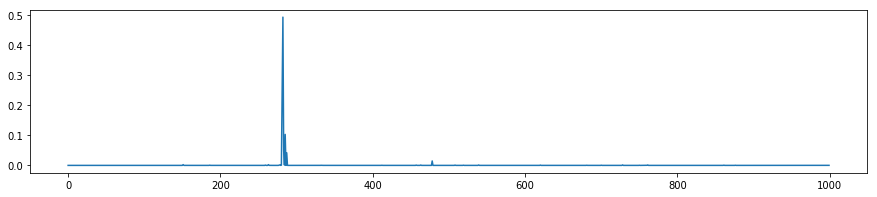

In [13]:
feat = net.blobs['prob'].data[0]
print 'feat.shape: ', feat.shape
plt.figure(figsize=(15, 3)) # (15*80,3*80)
plt.plot(feat.flat)

Note the cluster of strong predictions; the labels are sorted semantically. The top peaks correspond to the top predicted labels, as shown above.

### 6. Try your own image

Now we'll grab an image from the web and classify it using the steps above.

* Try setting `my_image_url` to any JPEG image URL.

--2018-04-13 21:04:12--  https://imgsa.baidu.com/baike/c0%3Dbaike80%2C5%2C5%2C80%2C26/sign=df76f2cfd52a6059461de948495d5ffe/94cad1c8a786c917f1474c3fcb3d70cf3bc7576b.jpg
Resolving imgsa.baidu.com (imgsa.baidu.com)... 106.38.179.48
Connecting to imgsa.baidu.com (imgsa.baidu.com)|106.38.179.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44552 (44K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]  43.51K  --.-KB/s    in 0.006s  

2018-04-13 21:04:12 (7.22 MB/s) - ‘image.jpg’ saved [44552/44552]

probabilities and labels:


[(0.47232622, 'n02109961 Eskimo dog, husky'),
 (0.2727825, 'n02110185 Siberian husky'),
 (0.23086306, 'n02110063 malamute, malemute, Alaskan malamute'),
 (0.009366322, 'n02114367 timber wolf, grey wolf, gray wolf, Canis lupus'),
 (0.006407532, 'n02114548 white wolf, Arctic wolf, Canis lupus tundrarum')]

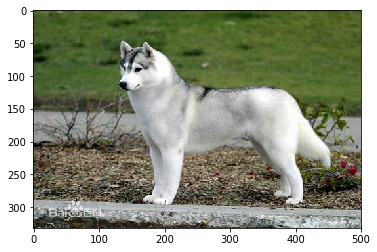

In [14]:
# download an image
#my_image_url = "..."  # paste your URL here
# for example:
#my_image_url = "https://imgsa.baidu.com/baike/c0%3Dbaike80%2C5%2C5%2C80%2C26/sign=910cb473fa1fbe090853cb460a096756/bd3eb13533fa828b4cd916e6f51f4134970a5a39.jpg"
my_image_url = "https://imgsa.baidu.com/baike/c0%3Dbaike80%2C5%2C5%2C80%2C26/sign=df76f2cfd52a6059461de948495d5ffe/94cad1c8a786c917f1474c3fcb3d70cf3bc7576b.jpg"
!wget -O image.jpg $my_image_url

# transform it and copy it into the net
image = caffe.io.load_image('image.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]

plt.imshow(image)

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])